In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.special as sc
import scipy.optimize
from scipy import interpolate

## Importing all the data

In [2]:
all_data_awstp=pd.read_csv("Table_Training_AWSTP.csv",encoding='utf-8')

In [3]:
all_data_mtlog=pd.read_csv("Table_Training_MTLOG.csv",encoding='utf-8')

In [4]:
all_data_utep5=pd.read_csv("Table_Training_UTEP5.csv",encoding='utf-8')

In [5]:
all_data=pd.read_csv("Table_Training_Complete.csv",encoding='utf-8')

In [6]:
col=all_data.columns.to_list()

In [7]:
def data(all_data,beg,end,col):
    l=[col[0]]
    l.extend(col[beg:end])
    return(all_data[l])

In [8]:
adme_utep=data(all_data_utep5,580,725,col)
adme_mtlog=data(all_data_mtlog,580,725,col)
adme_awstp=data(all_data_awstp,580,725,col)
adme_all=data(all_data,580,725,col)

In [9]:
time_utep=data(all_data_utep5,1,146,col)
time_mtlog=data(all_data_mtlog,1,146,col)
time_awstp=data(all_data_awstp,1,146,col)
time_all=data(all_data,1,146,col)

In [10]:
forecast_utep=data(all_data_utep5,146,291,col)
forecast_mtlog=data(all_data_mtlog,146,291,col)
forecast_awstp=data(all_data_awstp,146,291,col)
forecast_all=data(all_data,146,291,col)

In [11]:
time=all_data[col[:146]]

In [12]:
x=forecast_utep.columns.to_list()

In [13]:
def error(adme,col_err,forecast_eps):
    error_eps=adme.drop(['Date'],axis=1)-forecast_eps.values
    #error_eps.insert(0,'Date',adme['Date'])
    error_eps.columns=col_err
    error_eps=error_eps.fillna(-1)
    return(error_eps)

### Constants

In [14]:
theta0=1.26
alpha=0.08
dt=0.0069
max_change=1.01
max_iter2=100
max_iter1=50
gamma=0.2
eps=0.018
n=100
M,N=forecast_all.shape

In [15]:
def pe(eps,x,forecast):
    forecast_eps=forecast.drop(['Date'],axis=1)
    #forecast_eps=forecast.copy()
    m=forecast[x]<eps
    v=forecast[x]>=1-eps
    forecast_eps=forecast_eps.where(~m,eps)
    forecast_eps=forecast_eps.where(~v,1-eps)
    #forecast_eps['Date']=forecast['Date']
    return(forecast_eps)

In [16]:
forecast_eps_u=pe(eps,x,forecast_utep)
forecast_eps_m=pe(eps,x,forecast_mtlog)
forecast_eps_a=pe(eps,x,forecast_awstp)
forecast_eps_all=pe(eps,x,forecast_all)

In [17]:
col_err=['error_'+str(i) for i in range(1,146)]
err_u=error(adme_utep,col_err,forecast_eps_u)
err_m=error(adme_mtlog,col_err,forecast_eps_m)
err_a=error(adme_awstp,col_err,forecast_eps_a)
err_all=error(adme_all,col_err,forecast_eps_all)

In [30]:
def theta_t(theta_0, alpha, pe, pe_dot):
    return(max(theta_0,(theta_0*alpha + abs(pe_dot))/(min(pe,1-pe))))

# Moments

## First moment

In [31]:
def first_moment(v,p1,p2,theta1,theta2,theta_0,dt,n):
    if theta1==theta2: #meaning that theta is constant and we have the exact solution
        return(v*np.exp(-theta1*dt))
    else: #we approximate the ode with its forward euler form and make a linear interpolation on the forecast to better approximate the equation becaust it's not linear
        ds=dt/n
        m=np.zeros(n)
        m[0]=v
        for i in range(1,n):
            p=p1+(p2-p1)*i/n
            p_dot=(p2-p1)/dt
            theta=theta_t(theta_0,alpha,p,p_dot)
            m[i]=m[i-1]*(1-theta*ds)
    return(m)

## Second moment

In [32]:
def second_moment(v,theta1,theta2,theta_0,p1,p2,alpha,dt,n,m1):
    m2=np.zeros(n)
    m2[0]=v**2
    ds=dt/n
    if theta1!=theta2:
        for i in range(1,n):
            p=p1+(p2-p1)*((i-1)/n)
            p_dot=(p2-p1)/dt
            theta=theta_t(theta_0,alpha,p,p_dot)
            m2[i]=m2[i-1]+(-2*m2[i-1]*(theta+alpha*theta_0)+2*alpha*theta_0*m1[i-1]*(1-2*p)+2*alpha*theta_0*p*(1-p))*ds
    else:
        theta=theta1
        for i in range(1,n):
            p=p1+(p2-p1)*((i-1)/n)
            m1=v*np.exp(-theta*dt*((i-1)/n))
            m2[i]=m2[i-1]+(-2*m2[i-1]*(theta+alpha*theta_0)+2*alpha*theta_0*m1*(1-2*p)+2*alpha*theta_0*p*(1-p))*ds
    return(m2)

## Moment matching

In [21]:
def moment_matching(m1,m2):
    sig2=m2-m1**2
    xi1=-((m1+1)*(m1**2+sig2-1))/(2*sig2)
    xi2=((m1-1)*(m1**2+sig2-1))/(2*sig2)
    return(xi1,xi2)

In [22]:
def moment_matching_delta(m2):
    m1=0
    sig2=m2-m1**2
    xi1=-((m1+1)*(m1**2+sig2-1))/(2*sig2)
    xi2=((m1-1)*(m1**2+sig2-1))/(2*sig2)
    return(xi1,xi2)

### Log density

In [23]:
def log_density(v,xi1,xi2):
    a=-1
    b=1
    return(-sc.betaln(xi1,xi2)+(xi1-1)*np.log((v-a)/(b-a))+(xi2-1)*np.log((b-v)/(b-a)))

## Likelihood evaluation

In [24]:
M_u,N_u=forecast_eps_u.shape
M_m,N_m=forecast_eps_m.shape
M_a,N_a=forecast_eps_a.shape
M_all,N_all=forecast_eps_all.shape

In [336]:
def likelihood(M,N,n,forecast_eps,err,theta0,alpha,dt):
    likelihood=[]
    for i in range(M):
        for j in range(1,N-1):
            p0=forecast_eps.iloc[i,j-1]
            p1=forecast_eps.iloc[i,j]
            p2=forecast_eps.iloc[i,j+1]
            v1=err.iloc[i,j]
            v2=err.iloc[i,j+1]
            p1_dot=(p1-p0)/dt
            p2_dot=(p2-p1)/dt
            theta1=theta_t(theta0, alpha, p1, p1_dot)
            theta2=theta_t(theta0, alpha, p2, p2_dot)
            m1=first_moment(v1,p1,p2,theta1,theta2,theta0,dt,n)
            m2=second_moment(v1,theta1,theta2,theta0,p1,p2,alpha,dt,n,m1)
            if theta1!=theta2:
                m1=m1[len(m1)-1]
            m2=m2[len(m2)-1]
            xi1,xi2=moment_matching(m1,m2)
            if xi1<0 or xi2<0:
                likelihood.append(0)
            else:
                likelihood.append(log_density(v2,xi1,xi2))
    return(sum(likelihood))

In [33]:
def likelihood_delta(M,n,forecast_eps,err,theta0,alpha,delta,dt):
    likelihood=[]
    k=7
    for i in range(M):
        p1=forecast_eps.iloc[i,0]
        p2=forecast_eps.iloc[i,k]
        #t2=time_all.iloc[i,k]
        p0=p1 - delta*(p2-p1)/((k-1)*dt)
        p0 = min(1-0.018,p0)
        p0 = max(0.018,p0)
        v1=err.iloc[i,0]
        v0=0
        p0_dot=(p1-p0)/delta
        #p1_dot=(p2-p1)/((k-1)*dt)
        p1_dot=(forecast_eps.iloc[i,1]-p1)/(dt)
        theta1=theta_t(theta0, alpha, p0, p0_dot)
        theta2=theta_t(theta0, alpha, p1, p1_dot)
        m1=first_moment(v0,p0,p1,theta1,theta2,theta0,delta,n)
        m2=second_moment(v0,theta1,theta2,theta0,p1,p0,alpha,delta,n,m1)
        if theta1!=theta2:
            m1=m1[len(m1)-1]
        m2=m2[len(m2)-1]
        xi1,xi2=moment_matching(m1,m2)
        if xi1<0 or xi2<0:
            likelihood.append(0)
        else:
                likelihood.append(log_density(v1,xi1,xi2))
    return(sum(likelihood))

## Maximizing the log likelihood

In [33]:
def likelihood_opt(M,N,n,forecast_eps,err,theta0,alpha,dt):
    l = lambda x: -likelihood(M,N,n,forecast_eps,err,x[0],x[1],dt)
    opt = scipy.optimize.fmin(func=l, x0=[theta0,alpha])
    return(opt)

In [34]:
def likelihood_opt_delta(M,n,forecast_eps,err,theta0,alpha,delta,dt):
    l = lambda x: -likelihood_delta(M,n,forecast_eps,err,theta0,alpha,x,dt)
    opt = scipy.optimize.fmin(func=l, x0=delta,retall=0)
    return(opt)

In [35]:
delta=0.1
opt=likelihood_opt_delta(M,n,forecast_eps_all,err_all,theta0,alpha,delta,dt)

Optimization terminated successfully.
         Current function value: -74.233786
         Iterations: 10
         Function evaluations: 20


In [29]:
delta=opt[0]
delta

0.08406250000000004

## Path generation and confidence intervals

In [37]:
#just to add the date columns to the dataframe
def pe_date(eps,x,forecast):
    #forecast_eps=forecast.drop(['Date'],axis=1)
    forecast_eps=forecast.copy()
    m=forecast[x]<eps
    v=forecast[x]>=1-eps
    forecast_eps=forecast_eps.where(~m,eps)
    forecast_eps=forecast_eps.where(~v,1-eps)
    forecast_eps['Date']=forecast['Date']
    return(forecast_eps)

In [373]:
def pe_dot(forecast,dt):
    forecast_date=forecast.drop(['Date'],axis=1)
    forecast_dot=(forecast_date.shift(-1)-forecast_date)/dt
    forecast_dot=forecast_dot.drop(forecast_dot.index[len(forecast_dot)-1])
    forecast_dot['Date']=forecast['Date']
    return(forecast_dot)

In [374]:
def p_with_delta(forecast_eps,dt,delta,t0,t,k):
    l=['Forecast_0'+str(i) for i in range(len(t))]
    c=np.zeros(len(forecast_eps))
    x=list(forecast_eps['Date'])
    for j in range(len(l)-1,-1,-1):
        forecast_eps.insert(1,l[j],c)
    for i in range(M):
        p1=forecast_eps.iloc[i,len(l)+1]
        p2=forecast_eps.iloc[i,len(l)+k+2]
        y=[p1,p2]
        f=interpolate.interp1d(t0,y,fill_value='extrapolate')
        p0=f(t)
        p0 = np.minimum(1-0.018,p0)
        p0 = np.maximum(0.018,p0)
        forecast_eps.loc[forecast_eps['Date']==x[i],l]=p0
    return(forecast_eps)

In [389]:
k=7
t=np.linspace(-delta,-dt,int((delta-dt)/dt))
t0=[0,k*dt]

In [375]:
forecast_eps=pe_date(eps,x,forecast_all)

In [376]:
forecast_eps=p_with_delta(forecast_eps,dt,delta,t0,t,k)

In [401]:
num_sim=100
l0=[]
for i in list(forecast_eps['Date']):
    for j in range(1,num_sim+1):
        l0.append(str(i)+'_'+str(j))

In [390]:
def sde_prod(forecast_eps,theta0,alpha,time,dt,l0,num_sim,delta):
    forecast_dot=pe_dot(forecast_eps,dt)
    l00=['Forecast_0'+str(i) for i in range(int((delta-dt)/dt))]
    l01=['Forecast_'+str(i) for i in range(1,146)]
    l=l00+l01
    #l1=['Time_'+str(i) for i in range(1,146)]
    sim=pd.DataFrame(index=range(len(l0)),columns=range(len(l)))
    sim.columns=l
    sim['Date_plot']=l0
    #for i in list(forecast_dot['Date'])[:len(list(forecast_dot['Date']))-1]:
    for i in list(forecast_dot['Date'])[0:1]:
        print(i)
        for k in range(1,num_sim+1):
            c=str(i)+'_'+str(k)
            sim.loc[sim['Date_plot']==c,'Forecast_00']=float(forecast_eps.loc[forecast_eps['Date']==i,'Forecast_00'])
            p=float(forecast_eps.loc[forecast_eps['Date']==i,l[0]])
            p2=float(forecast_eps.loc[forecast_eps['Date']==i,l[1]])
            p_dot=(p2-p)/delta
            sim1=float(sim.loc[sim['Date_plot']==c,l[0]])
            theta=theta_t(theta0,alpha,p,p_dot)
            dW=np.sqrt(dt)*np.random.randn(1)
            sim.loc[sim['Date_plot']==c,l[1]]=sim1+(p_dot-theta*(sim1-p))*dt+np.sqrt(2*alpha*theta0*sim1*(1-sim1))*dW[0]
            if float(sim.loc[sim['Date_plot']==c,l[1]])<0:
                sim.loc[sim['Date_plot']==c,l[1]]=0
            elif float(sim.loc[sim['Date_plot']==c,l[1]])>1:
                sim.loc[sim['Date_plot']==c,l[1]]=1
            for j in range(1,len(l)-1):
                p=float(forecast_eps.loc[forecast_eps['Date']==i,l[j]])
                p2=float(forecast_eps.loc[forecast_eps['Date']==i,l[j+1]])
                p_dot=(p2-p)/dt
                sim1=float(sim.loc[sim['Date_plot']==c,l[j]])
                theta=theta_t(theta0,alpha,p,p_dot)
                dW=np.sqrt(dt)*np.random.randn(1)
                sim.loc[sim['Date_plot']==c,l[j+1]]=sim1+(p_dot-theta*(sim1-p))*dt+np.sqrt(2*alpha*theta0*sim1*(1-sim1))*dW[0]
                if float(sim.loc[sim['Date_plot']==c,l[j+1]])<0:
                    sim.loc[sim['Date_plot']==c,l[j+1]]=0
                elif float(sim.loc[sim['Date_plot']==c,l[j+1]])>1:
                    sim.loc[sim['Date_plot']==c,l[j+1]]=1
    return(sim)

In [381]:
sim=sde_prod(forecast_eps,theta0,alpha,time,dt,l0,num_sim,delta)

20190101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [ ]:
sim.to_csv('simc.csv',index=False)

## Simulation plots & confidence intervals

In [402]:
sim=pd.read_csv('simc.csv')
sim=sim.dropna()
sim

Forecast_00  Forecast_01  Forecast_02  Forecast_03  Forecast_04  \
0         0.810813     0.817140     0.832176     0.835315     0.823489   
1         0.810813     0.798662     0.789726     0.766603     0.755529   
2         0.810813     0.792609     0.779778     0.762988     0.764288   
3         0.810813     0.795028     0.791262     0.793002     0.762252   
4         0.810813     0.795135     0.776467     0.762919     0.740294   
...            ...          ...          ...          ...          ...   
12495     0.712923     0.685422     0.690110     0.670714     0.683602   
12496     0.712923     0.700448     0.691027     0.685960     0.680213   
12497     0.712923     0.716158     0.706012     0.713411     0.706305   
12498     0.712923     0.722713     0.709797     0.692620     0.662967   
12499     0.712923     0.712583     0.703715     0.694811     0.700516   

       Forecast_05  Forecast_06  Forecast_07  Forecast_08  Forecast_09  ...  \
0         0.823225     0.815215     0.821448     0.795254     0.789210  ...   
1         0.751980     0.727862     0.693625     0.680171     0.672542  ...   
2         0.743825     0.746952     0.752954     0.733798     0.710300  ...   
3         0.767377     0.735311     0.704695     0.706690     0.704483  ...   
4         0.728163     0.707020     0.701863     0.681773     0.649864  ...   
...            ...          ...          ...          ...          ...  ...   
12495     0.658048     0.657096     0.670076     0.689459     0.688398  ...   
12496     0.665962     0.684103     0.684179     0.651588     0.650909  ...   
12497     0.711684     0.725358     0.710349     0.729952     0.765185  ...   
12498     0.655824     0.644450     0.634966     0.611798     0.596045  ...   
12499     0.702534     0.705303     0.679722     0.677357     0.697785  ...   

       Forecast_137  Forecast_138  Forecast_139  Forecast_140  Forecast_141  \
0          0.390308      0.375142      0.373868      0.374052      0.384022   
1          0.576557      0.581698      0.591862      0.601551      0.615352   
2          0.428706      0.447435      0.441692      0.442880      0.415224   
3          0.338924      0.353709      0.333682      0.310119      0.299895   
4          0.515350      0.520316      0.540120      0.558150      0.561609   
...             ...           ...           ...           ...           ...   
12495      0.344969      0.332877      0.335245      0.315433      0.295082   
12496      0.295973      0.278985      0.266441      0.268163      0.259474   
12497      0.516636      0.505027      0.506228      0.503518      0.506933   
12498      0.549404      0.566087      0.552736      0.540107      0.532613   
12499      0.411224      0.421122      0.394182      0.405839      0.392240   

       Forecast_142  Forecast_143  Forecast_144  Forecast_145     Date_plot  
0          0.373413      0.383035      0.389754      0.394642    20190101_1  
1          0.642041      0.649737      0.632110      0.638616    20190101_2  
2          0.390545      0.383028      0.362249      0.355926    20190101_3  
3          0.318709      0.308950      0.297724      0.273120    20190101_4  
4          0.550174      0.539609      0.546240      0.569889    20190101_5  
...             ...           ...           ...           ...           ...  
12495      0.311039      0.274764      0.266041      0.254480   20190514_96  
12496      0.251679      0.273815      0.272007      0.269192   20190514_97  
12497      0.501464      0.510699      0.511400      0.494755   20190514_98  
12498      0.529160      0.536499      0.523560      0.492483   20190514_99  
12499      0.400983      0.391264      0.389395      0.401457  20190514_100  

[12500 rows x 157 columns]

### Confidence intervals

In [38]:
os.chdir('plots')
k=-1
t=list(np.linspace(-delta,-dt,int((delta-dt)/dt)))
l00=['Forecast_0'+str(i) for i in range(int((delta-dt)/dt))]
l01=['Forecast_'+str(i) for i in range(1,146)]
l=l00+l01
beg=0
end=100
kk=0
for i in list(forecast_eps['Date'])[:len(list(forecast_eps['Date']))-2]:
#for i in list(forecast_eps['Date'])[0:1]:
    q=np.zeros((len(l),6))
    c=sim.iloc[beg:end]
    k=0
    for j in l:
        y0=(list(c[j]))
        q[k,:]=np.quantile(y0,[0.01, 0.10, 0.25, 0.75, 0.90, 0.99])
        k+=1
    t1=list(time[time['Date']==i].iloc[0])[1:]
    t00=list(t)+t1
    #fig, ax = plt.subplots()
    beg=end
    end+=100
    plt.plot(t1,list(adme_all[adme_all['Date']==i].iloc[0])[1:],'b',linewidth=2)
    plt.plot(t1,list(forecast_all[forecast_all['Date']==i].iloc[0])[1:],'g',linewidth=2)
    plt.fill_between(t00,q[:,0] ,q[:,5], color='y', alpha=.5)
    plt.fill_between(t00,q[:,1] ,q[:,4], color='m', alpha=.5)
    plt.fill_between(t00,q[:,2] ,q[:,3], color='r', alpha=.5)
    plt.legend(['Real production','Forecast','99% confidence interval','90% confidence interval','50% confidence interval'])
    plt.xlabel('Time')
    plt.ylabel('Production normalized')
    plt.title(str(i))
    #fig.set_size_inches(8,8)
    #plt.figure(figsize=(8,8))
    plt.savefig('bands'+str(kk)+'.eps',dpi=1000)
    kk+=1
    plt.show()

NameError: name 'forecast_eps' is not defined

### Simulations

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


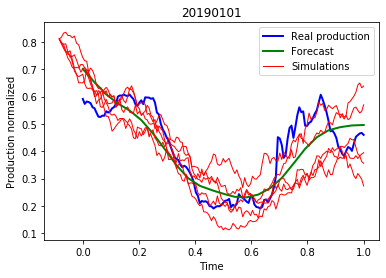

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


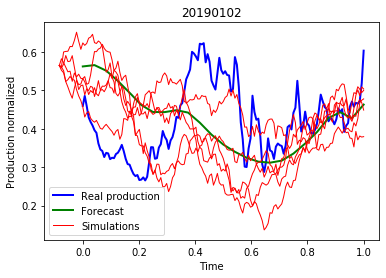

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


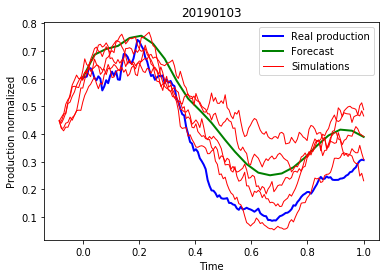

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


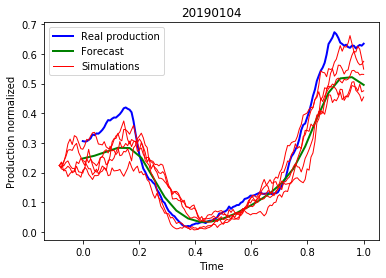

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


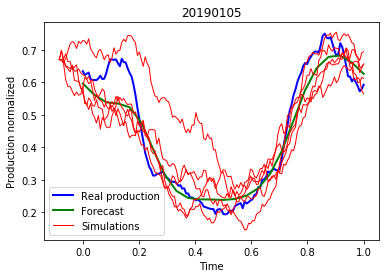

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


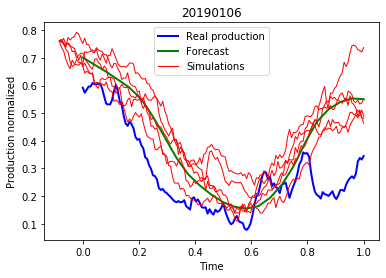

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


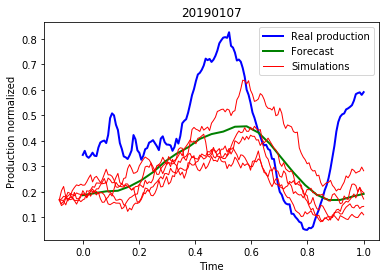

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


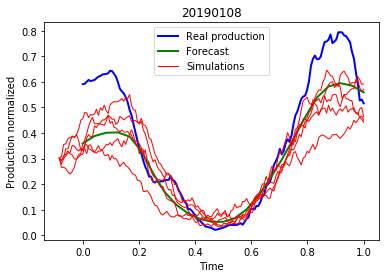

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


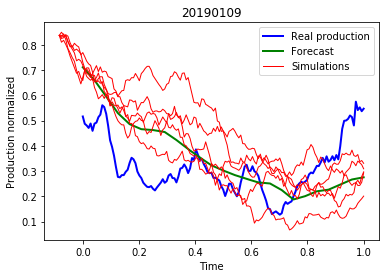

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


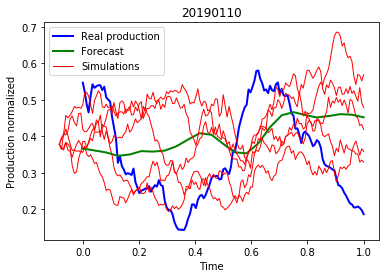

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


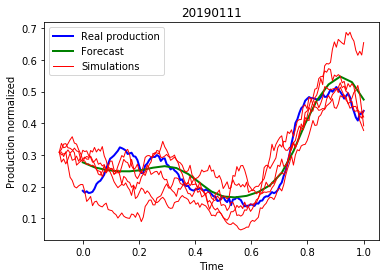

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


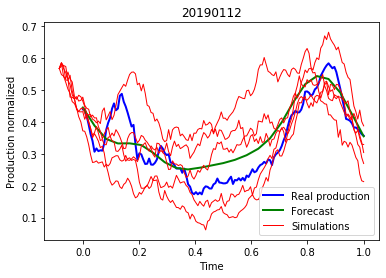

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


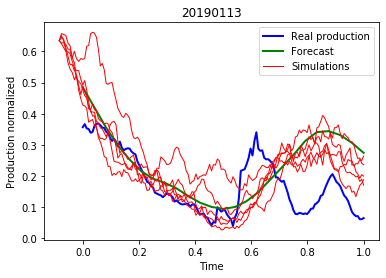

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


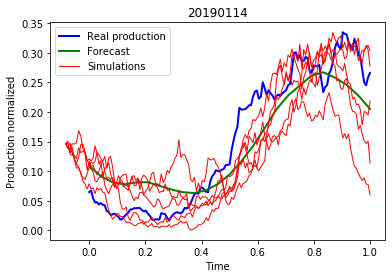

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


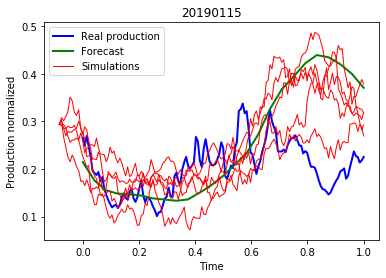

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


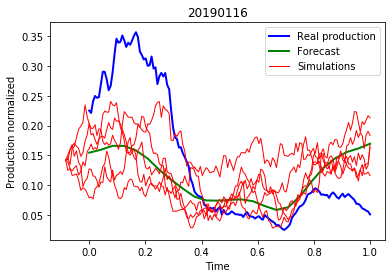

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


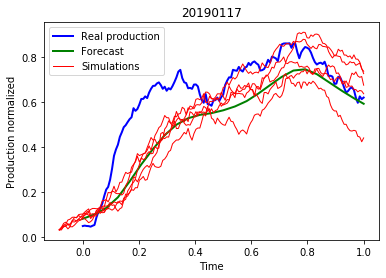

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


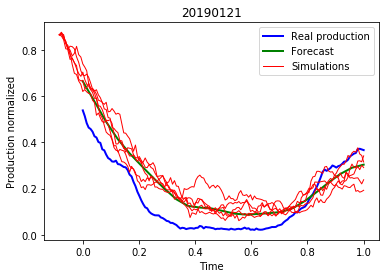

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


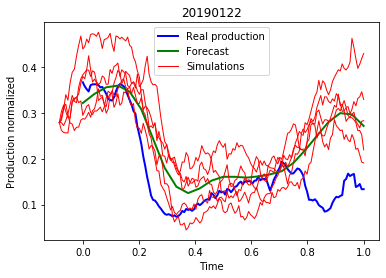

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


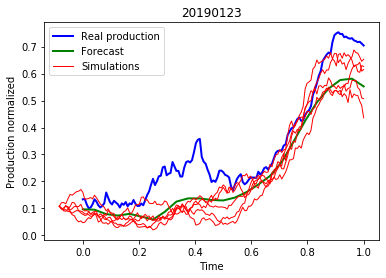

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


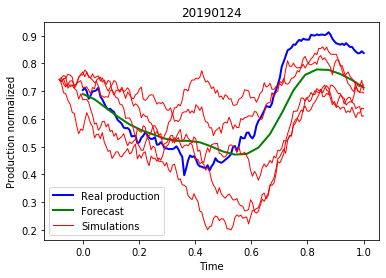

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


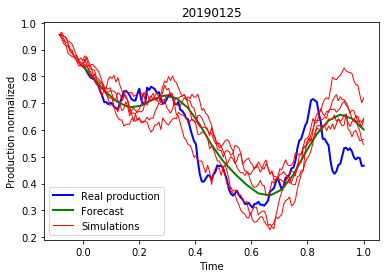

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


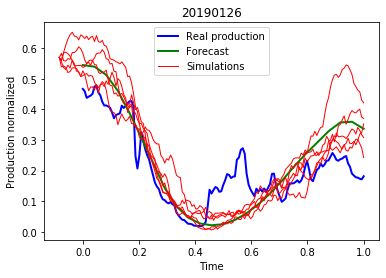

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


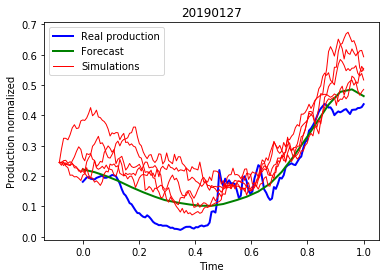

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


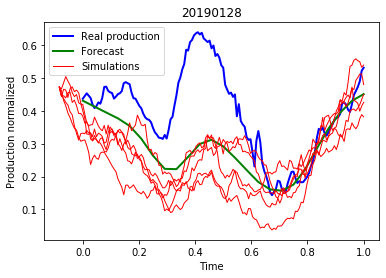

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


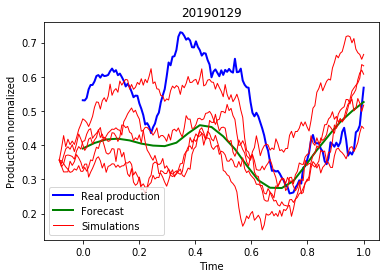

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


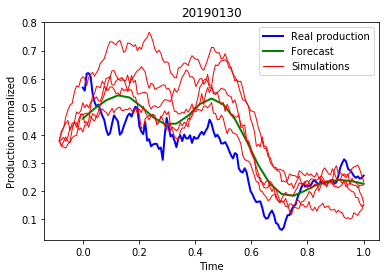

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


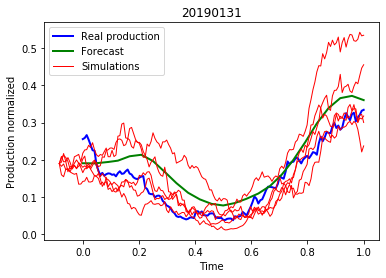

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


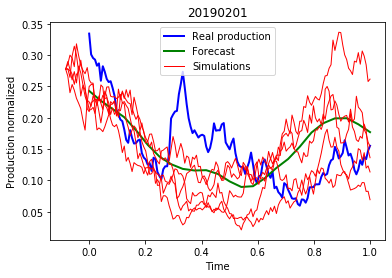

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


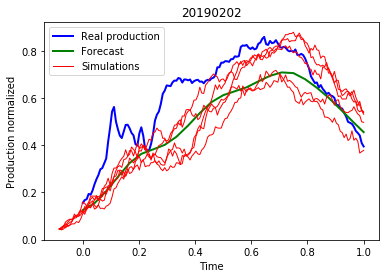

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


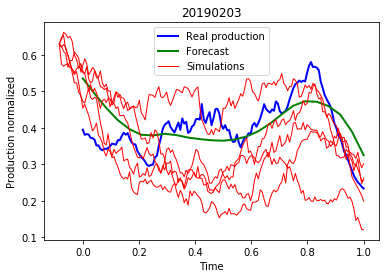

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


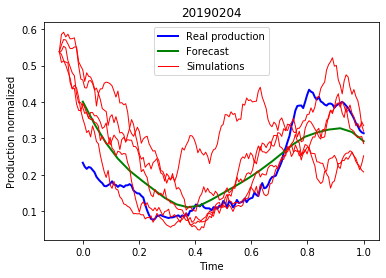

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


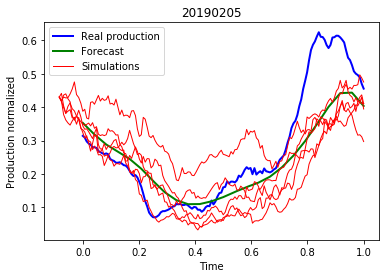

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


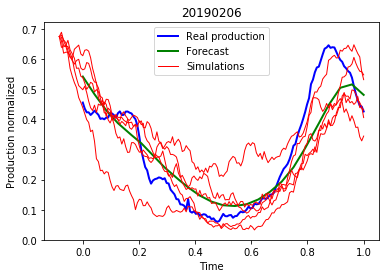

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


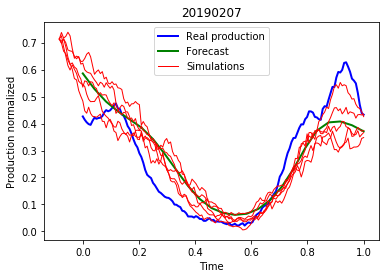

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


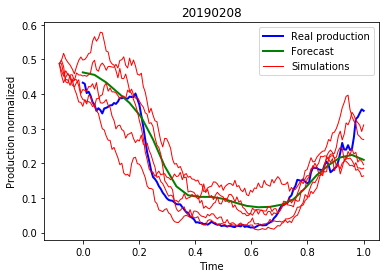

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


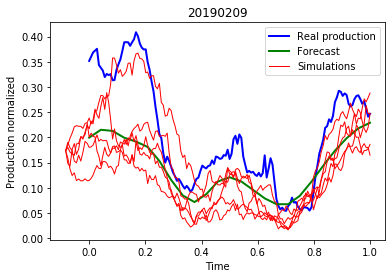

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


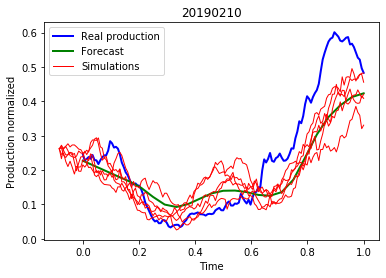

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


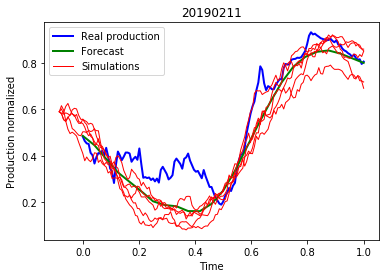

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


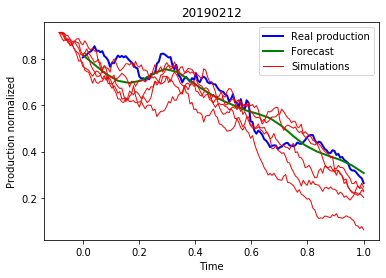

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


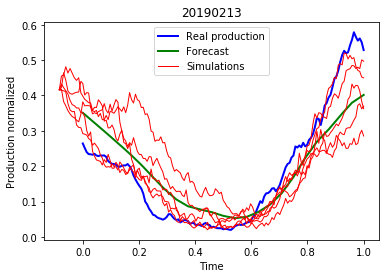

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


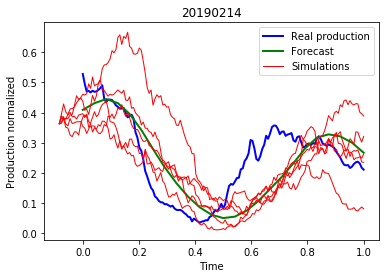

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


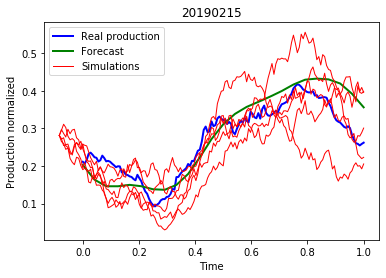

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


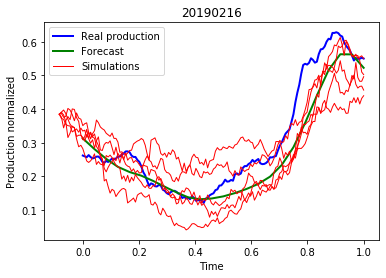

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


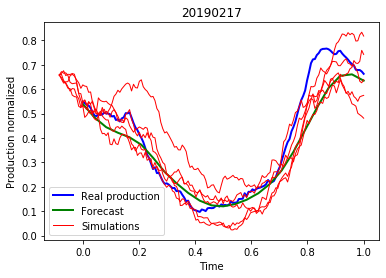

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


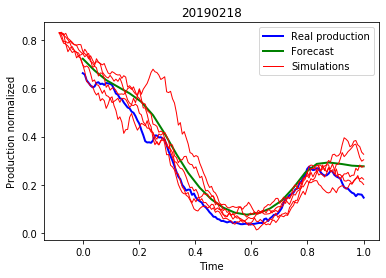

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


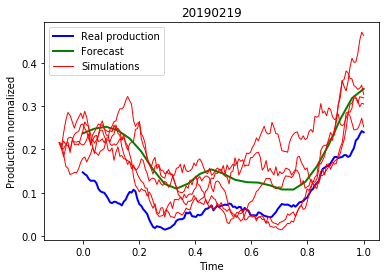

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


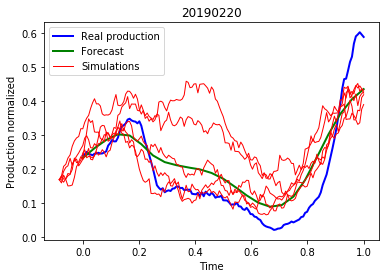

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


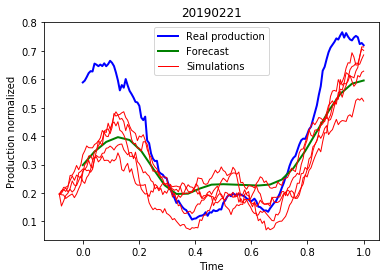

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


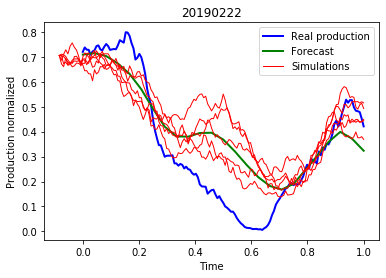

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


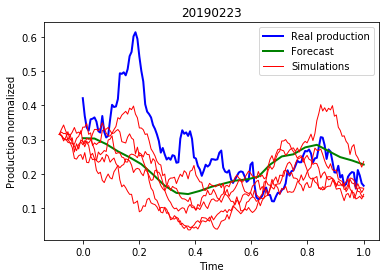

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


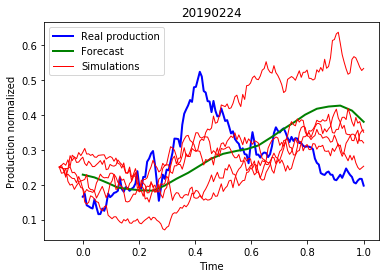

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


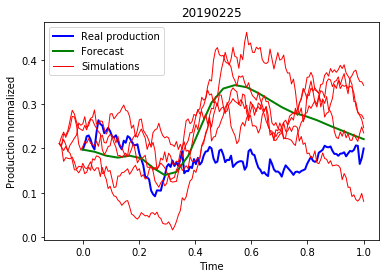

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


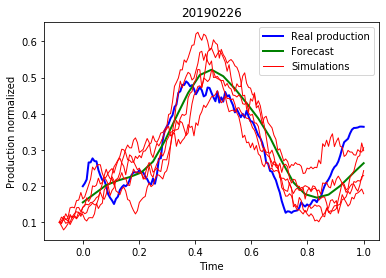

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


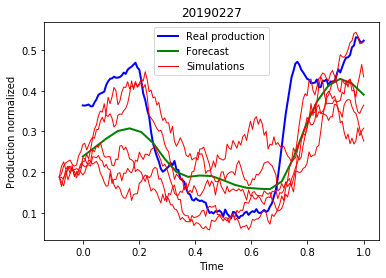

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


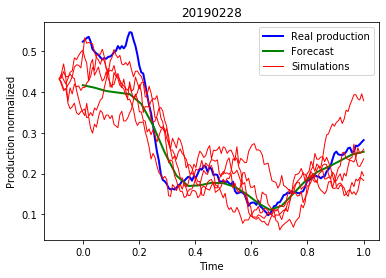

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


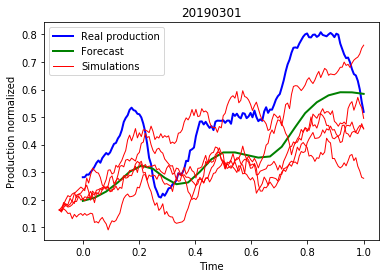

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


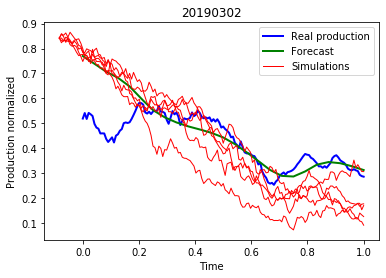

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


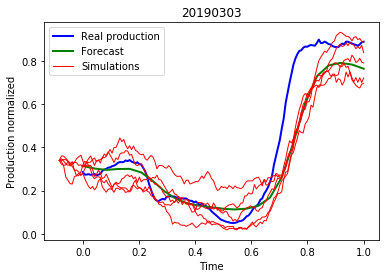

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


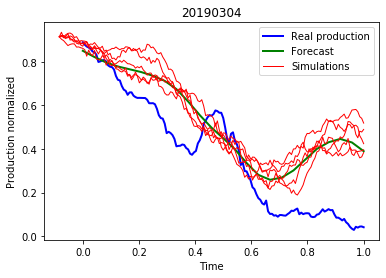

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


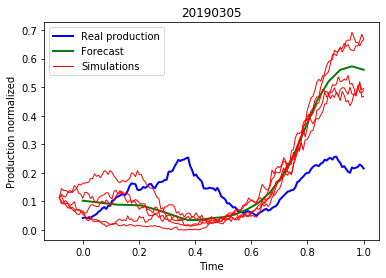

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


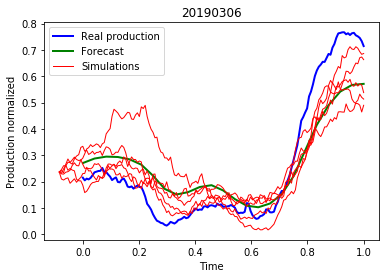

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


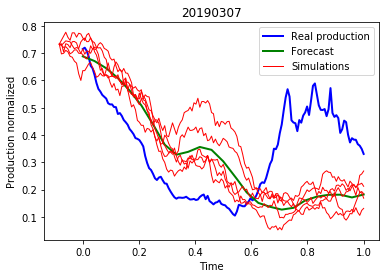

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


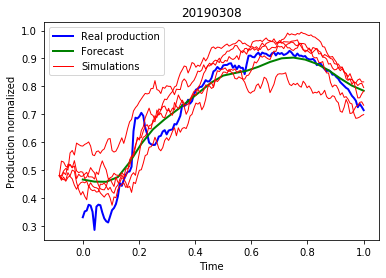

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


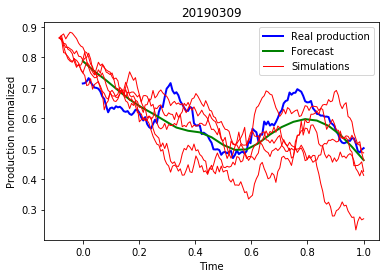

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


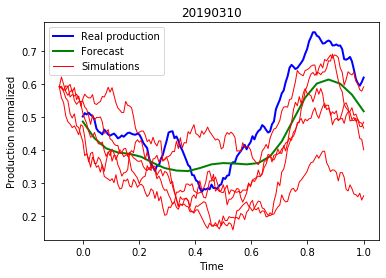

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


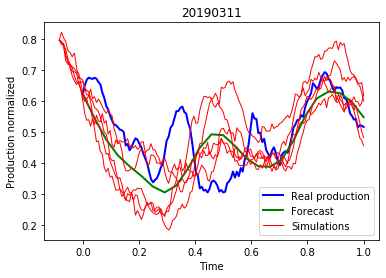

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


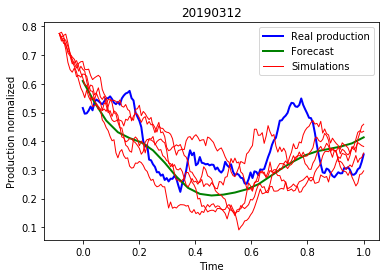

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


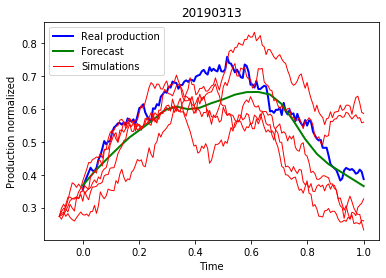

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


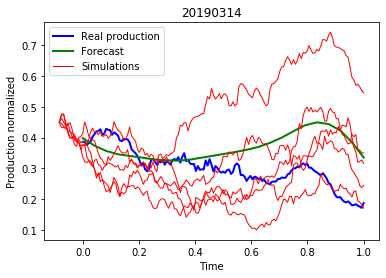

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


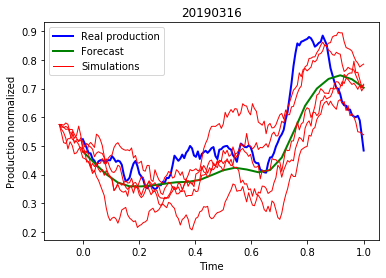

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


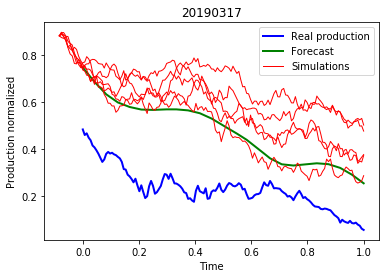

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


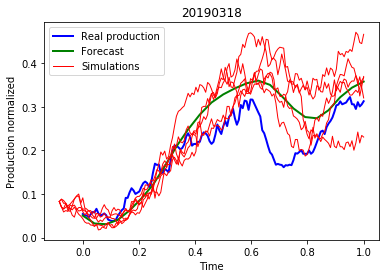

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


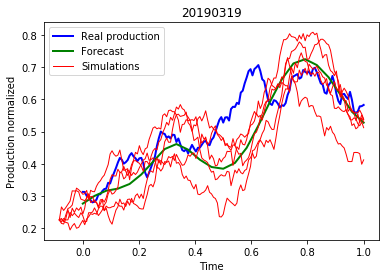

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


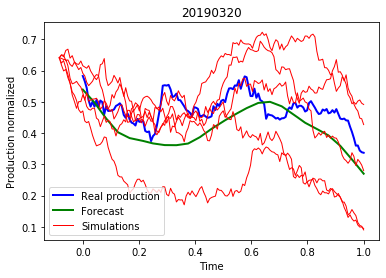

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


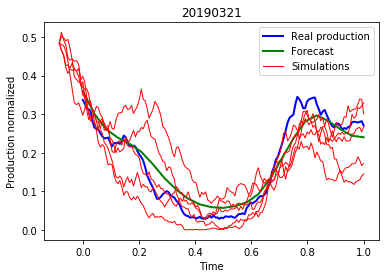

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


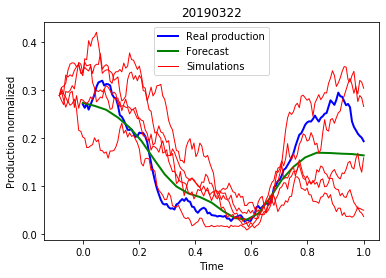

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


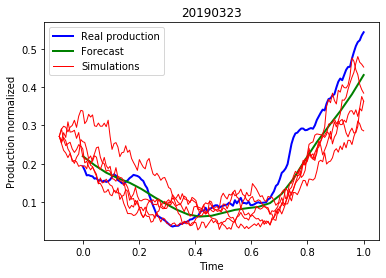

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


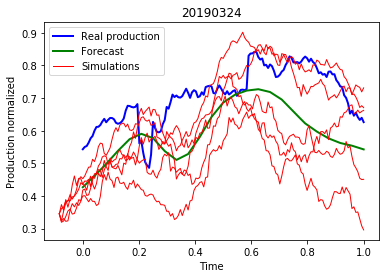

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


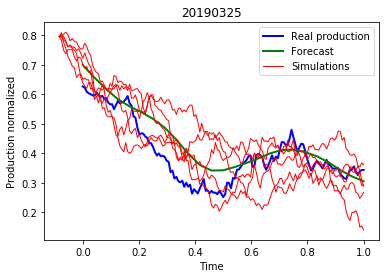

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


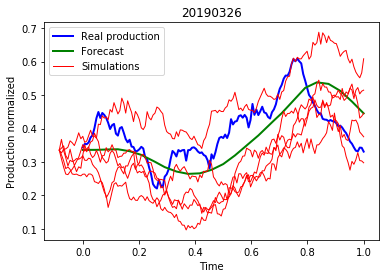

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


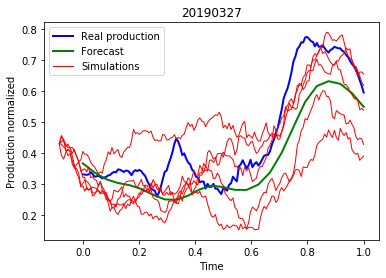

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


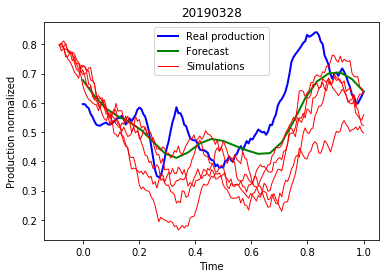

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


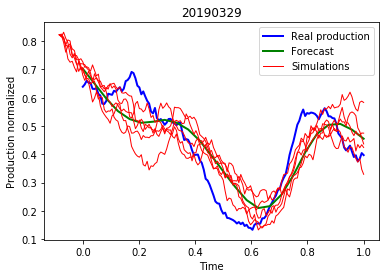

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


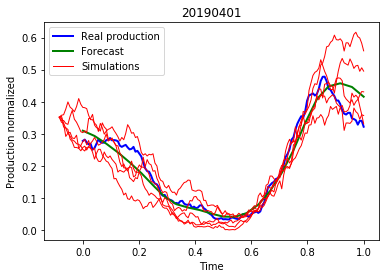

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


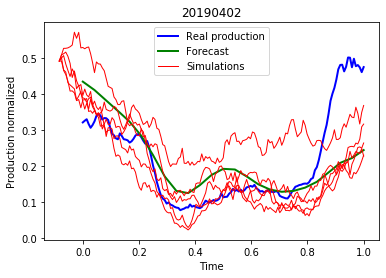

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


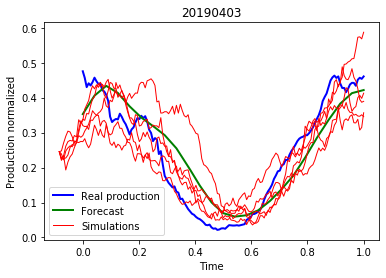

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


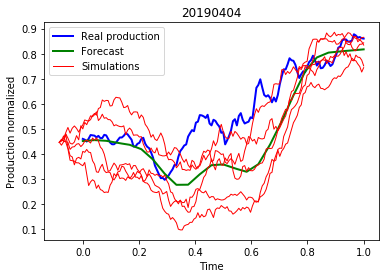

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


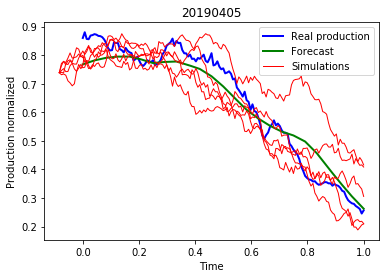

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


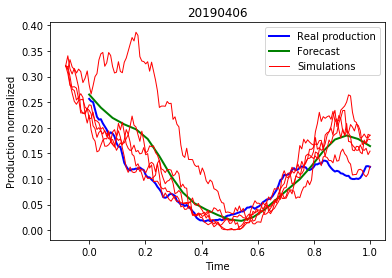

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


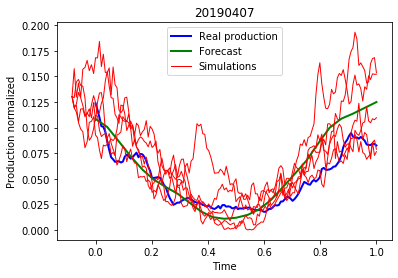

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


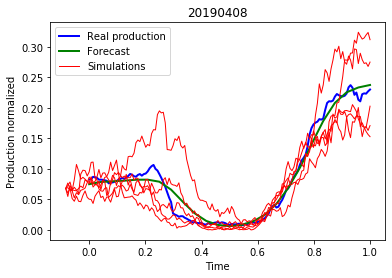

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


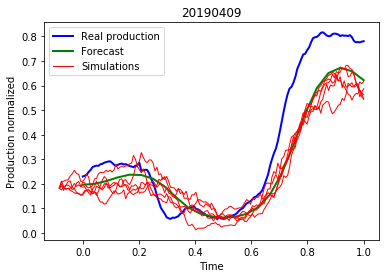

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


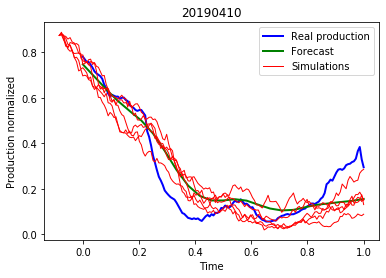

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


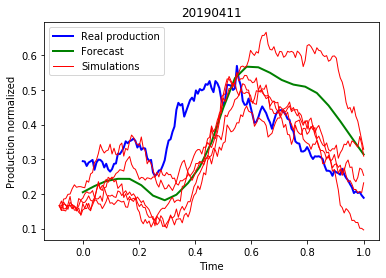

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


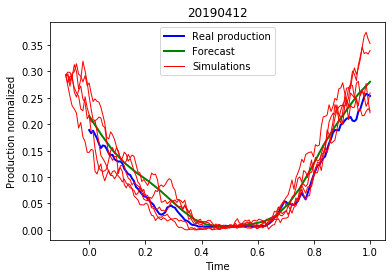

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


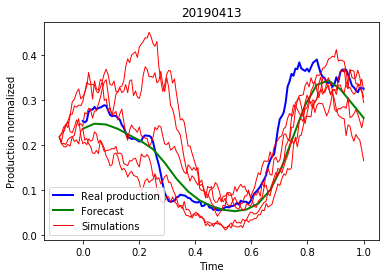

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


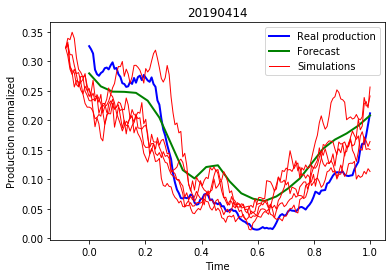

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


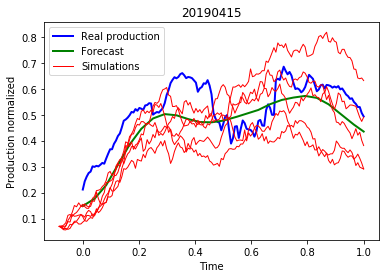

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


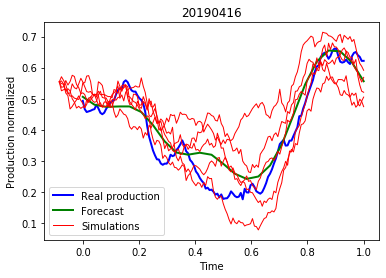

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


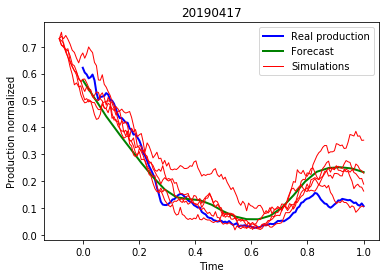

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


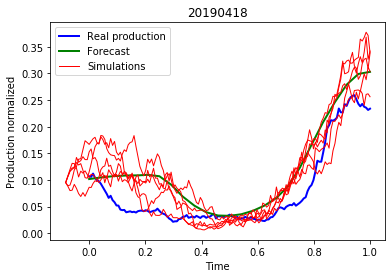

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


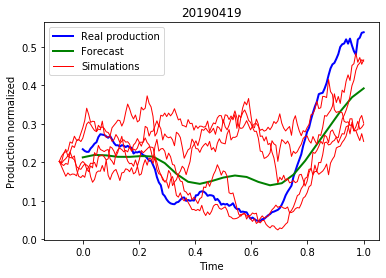

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


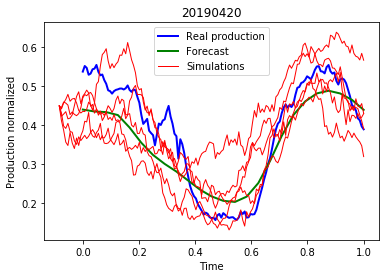

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


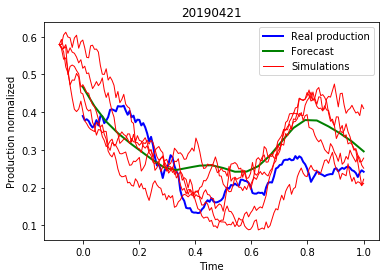

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


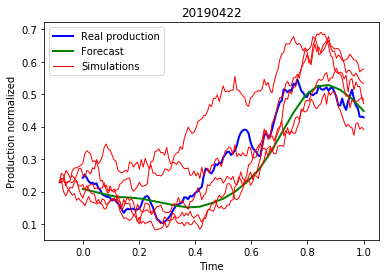

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


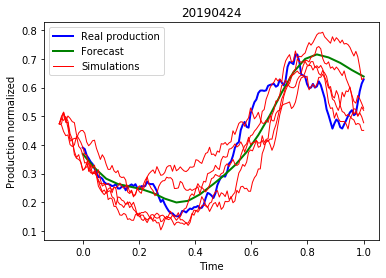

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


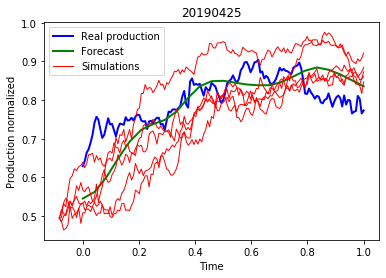

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


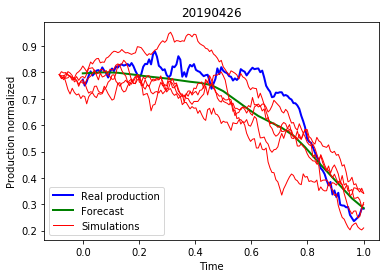

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


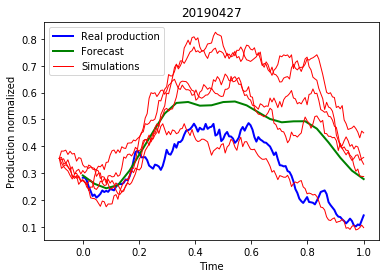

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


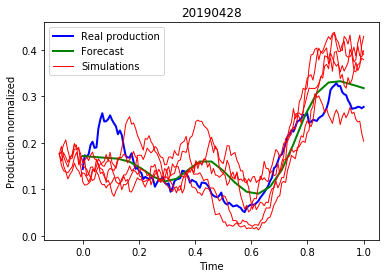

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


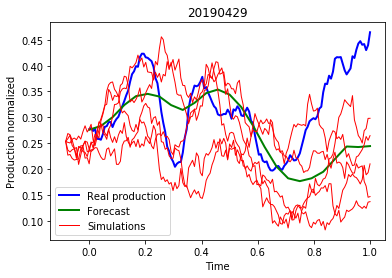

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


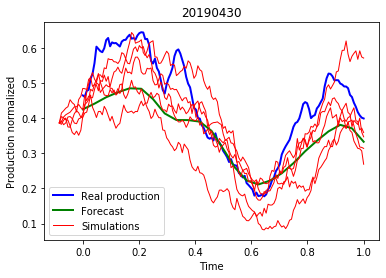

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


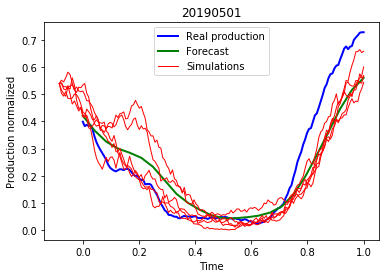

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


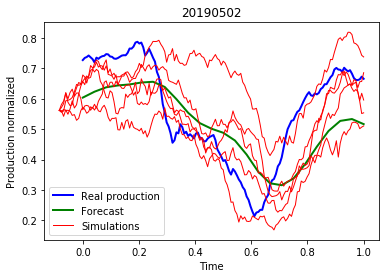

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


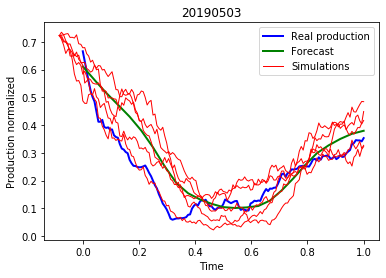

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


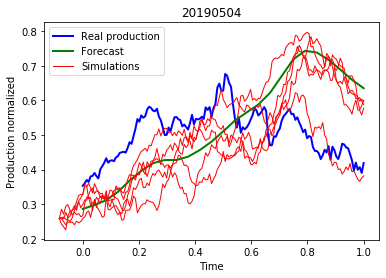

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


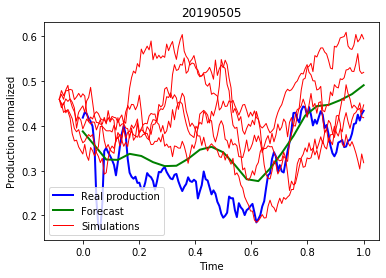

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


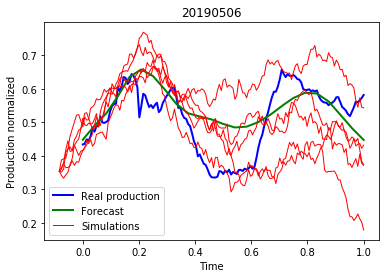

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


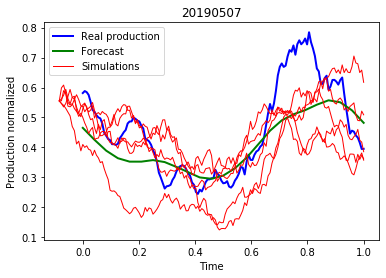

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


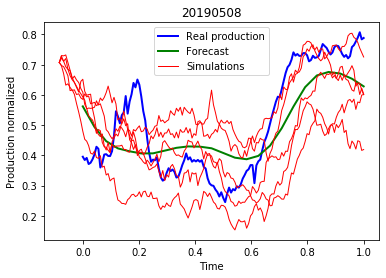

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


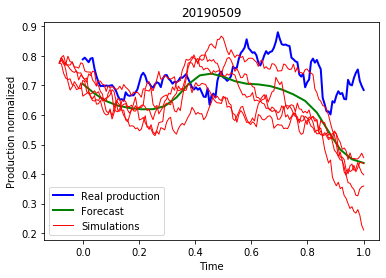

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


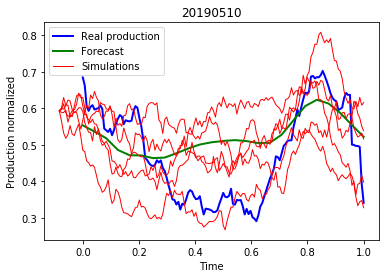

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


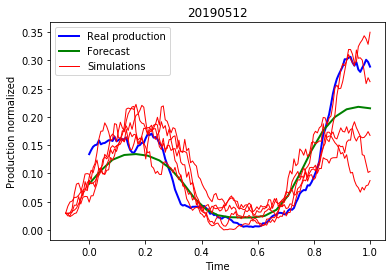

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


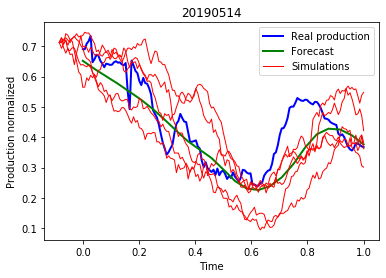

IndexError: single positional indexer is out-of-bounds

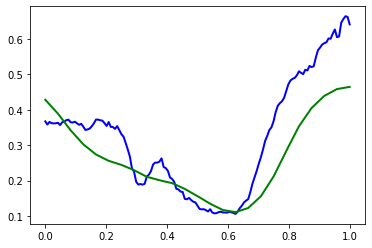

In [412]:
os.chdir('plots')
k=-1
t=list(np.linspace(-delta,-dt,int((delta-dt)/dt)))
l00=['Forecast_0'+str(i) for i in range(int((delta-dt)/dt))]
l01=['Forecast_'+str(i) for i in range(1,146)]
l=l00+l01
for i in list(forecast_eps['Date'])[:len(list(forecast_eps['Date']))-1]:
    k+=1
    t1=list(time[time['Date']==i].iloc[0])[1:]
    t00=list(t)+t1
    #fig, ax = plt.subplots()
    plt.plot(t1,list(adme_all[adme_all['Date']==i].iloc[0])[1:],'b',linewidth=2)
    plt.plot(t1,list(forecast_all[forecast_all['Date']==i].iloc[0])[1:],'-g',linewidth=2)
    for j in range(1,6):
        c=str(i)+'_'+str(j)
        y=list(sim[sim['Date_plot']==c].iloc[0])[:len(l)]
        plt.plot(t00,y,'r',linewidth=1)
    plt.legend(['Real production','Forecast','Simulations'])
    plt.xlabel('Time')
    plt.ylabel('Production normalized')
    plt.title(str(i))
    #fig.set_size_inches(8,8)
    #plt.figure(figsize=(8,8))
    plt.savefig('paths'+str(k)+'.eps',dpi=1000)
    plt.show()